# IZA paper - Empirical example

This notebook accompanies the paper ***Add reference***, and provides a guide on how to implement the approaches introduced in the paper in Python.

The data used for these examples comes from Lauren Jones and Nicolas Ziebarth, "[Successful Scientific Replication and Extension of Levitt (2008): Child Seats Are Still No Safer than Seat Belts](https://onlinelibrary.wiley.com/doi/epdf/10.1002/jae.2449)", *Journal of Applied Econometrics*, Vol. 31, No. 5, 2016, pp. 920-928. The Journal of Applied Econometrics publishes replication data in an easy to use format. The data used in that paper and in this notebook can be downloaded [here](http://qed.econ.queensu.ca/jae/datasets/jones004/). The link also contains a brief description of the variables in the dataset.

To be able to run this notebook, make sure that the data is unzipped in the `data/` folder.

In this notebook we guide the reader into three main application of machine learning for policy analysis:
1. Double Machine Learning (DML, or how to get the most out of your controls)
1. Causal Forests (CF, or how to automatically search for systematic heterogeneity in treatment effects)
1. Policy Learning (or ...)

The next cells imports the necessary modules, some of which are user-written.
The key import for policy evaluation with machine learning is [`econml`](https://econml.azurewebsites.net/), a package developed by Microsoft's research team as part of their [Alice](https://www.microsoft.com/en-us/research/group/alice/) initiative. The package implements Double Machine Learning approaches, Causal Forests, Policy Learning, Deep IV etc.

With respect to corresponding R packages, `econml` is more oriented at production. As such, it integrates very easily with well-known machine learning suites such as [`scikit-learn`](https://scikit-learn.org/stable/) and [`xgboost`](https://xgboost.readthedocs.io/en/latest/), and can be readily plugged into a ML/data pipeline. However, inference and diagnostic tools are (as of the version used for this notebook - 0.12.0b5) less developed than in the R modules. For example, handling clusters in the python package requires manual manipulation and recoding of standard error procedures. As a consequence, the examples in this notebook gloss overclustered standard error calculations and model diagnostics (some diagnostic tools are nonetheless provided by the user-written `DML_diagnostic` class in `src/dmlutils.py`).

In [2]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm

from pathlib import Path
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingClassifier, HistGradientBoostingRegressor
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold
#from econml.dml import LinearDML, CausalForestDML
from copy import deepcopy
from IPython.display import display

# User-written utilities - these are under src/ in the GitHub repositories 
import sys
sys.path.append('..')
import src.config as cfg
import src.features as ft
import src.data as sdt
from src.dmlutils import DML_diagnostics

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


The next cell loads the example datasets, and preprocesses them to ensure compatibility with the data used in the Jones and Ziebarth (2016). The two datasets are:
* **df_repl**: The full sample dataset, where the relationship between treatment and outcome is not identified (i.e. not causal) 
* **df_sel**: The selected dataset that, according to the identification strategy of Levitt (2008), makes the assumption of treatment unconfoudedness acceptable. See Levitt (2008) and Jones and Ziebarth (2016) for more details. 

In [3]:
# Load datasets
df_repl = sdt.preprocess_dataframe(pd.read_csv(Path('../data/FARS-data-full-sample.txt'), sep='\t'))
df_sel = sdt.preprocess_dataframe(pd.read_csv(Path('../data/FARS-data-selection-sample.txt'), sep='\t'))
print(f'Number of observations in the data: {df_repl.shape[0]} (full sample); {df_sel.shape[0]} (selected/causal sample)')

Number of observations in the data: 38455 (full sample); 10328 (selected/causal sample)


The next cell initiates two object for 1) automated data processing and 2) cross-valiation.

The first object is not crucial, but it ensures replicability of data processing. By calling its `fit_transform()` method, categorical controls are turned into dummies consistently. The object is a `sklearn.pipeline.Pipeline`.

The second object is crucial for ML approaches, which require estimations out-of-bag. In its simplest form, DML, orthogonalizations are done by fitting a ML model on a random half of the sample to then computing residuals on the other, and viceversa. Initializing the object responsible for these splits with a prespecified random seed is crucial for consistency of results across runs and replicability.

In [4]:
pipe = ft.construct_data_pipeline(pd_output=True)
cv_splitter = KFold(2, shuffle=True, random_state=cfg.random_state)

    ## Double Machine Learning: Or *How to get as much as possible out of your controls*

### Full sample analysis

This section replicates the results of Jones and Ziebarth (2016), henceforth JZ, on the full sample. These results appear in table 1 of the paper. JZ look at the effect that each of the treatment arms (childseat, lap-only belt, or lap and shoulder belt) has on mortality with respect to the null of no protection, which applies to the majority of the sample.

The following table shows the frequency of each treatment arm in this sample.

In [5]:
y = df_repl['death']
T = df_repl['restraint']
W = df_repl[[col for col in df_repl.columns if col not in ['lapbelt', 'lapshould', 'childseat']]]
T.value_counts().to_frame().sort_index()

,restraint
0_norestrain,20471
1_childseat,7409
2_lap only belt,4932
3_lap/should belt,5643


JZ, like Levitt (2008), use a linear probability model, and include controls as dummies or fixed effects to investigate the relationship between treatment and mortality. In this sample there is no identification, but we can still investigate whether including control variables in a non-linear way, and thereby allowing for arbitrary interactions between them, affects the results.

To do so, we initialize three models:
1. A ML model to predict the treatment `T` out of the available set of controls `W`
1. A ML model to predict the outcome `y` out of the available set of controls `W`
1. A second stage linear Double Machine Learning Model (DML) to orthogonalize the data using the first-stage models. Note that the class is initalized with the predefined `cv_splitter`, in order to ensure out-of-sample orthogonalization.

As first-stage ML models we use [gradient boosted trees](), a popular model that typically performs very well in tabular medium-to-large datasets. The python `econml` interfacte allows for any class with a `.fit()` and `.predict()/.predict_proba()` method, so for example any model in the `scikit-learn` environment will do. Note that as the treatment has multiple arms, `econml` allows to specify a multinomial ML model (e.g. a multinomial logit) as first-stage model for T. Then `LinearDML` will orthogonalize automatically for each treatment arm. An alternative would be to estimate three spearate models, one for each treatment arm.

The next cell initializes the DML model, fits them twice (the first time without controls, so without orthogonalization), and prints its results.

In [6]:
%%time
# Initialize model(s)
model_t = HistGradientBoostingClassifier(max_iter=100, n_iter_no_change=10, max_depth=5, early_stopping=True, random_state=cfg.random_state)
model_y = HistGradientBoostingRegressor(max_iter=100, n_iter_no_change=10, max_depth=5, early_stopping=True, random_state=cfg.random_state)
dml = LinearDML(model_t=model_t, model_y=model_y, cv=cv_splitter, discrete_treatment=True, fit_cate_intercept=True)

# Fit DML
dml_nocontrols = deepcopy(dml).fit(y, T.values)
dml.fit(y, T.values, W=pipe.fit_transform(W))

# Show effects
print('Without controls')
inf = dml_nocontrols.intercept__inference()
display(inf.summary_frame())
print('With controls')
inf = dml.intercept__inference()
display(inf.summary_frame())

NameError: name 'LinearDML' is not defined

The first table matches perfectly the results of JZ. The second table shows slightly different point estimates, as linear and non-linear orthogonalization differ, but there is no evidence that in this specific case controlling for `W` in a non-linear fashion matters much. 

Non-linear interactions and non-linearities in the controls in other words do not seem to matter much in this case. This result is not totally unexpected, as most of these controls are simple dummies. We can see that by comparing the out-of-sample explanatory powers of the first-stage models with simple linear regressions.  

#### Comparison with OLS benchmark

To do that, we simply initalize a DML model with OLS regressions as first stages. Then we compare out-of-sample $R^2$ for whether a row was treated (in any way) or not.

Out-of-sample $R^2$ are obtained thanks to the `cv_cplitter` class. This allows models to be trained on half of the sample, and evaluated on the other half. The results for the two modesl are then averaged. This type of diagnostic is currently unavailable in `econml`, and is coded in the user-written class `DML_Diagnostics`)

In [6]:
%%time
Tb = T.str[0].astype(int)>0
model_t = LinearRegression()
model_y = LinearRegression()
bmark = LinearDML(model_t=model_t, model_y=model_y, cv=cv_splitter, discrete_treatment=False, fit_cate_intercept=True)
bmark.fit(y, Tb.values, W=pipe.fit_transform(W))

diag = DML_diagnostics(dml)
bdiag = DML_diagnostics(bmark)
pd.DataFrame([
        [r2_score(y, diag.predict_y(W=pipe.transform(W))), r2_score(T.str[0].astype(int)>0, diag.predict_T(W=pipe.transform(W)))],
        [r2_score(y, bdiag.predict_y(W=pipe.transform(W))), r2_score(Tb, bdiag.predict_T(W=pipe.transform(W)))]
    ]
    , index=['DML', 'OLS (benchmark)'], columns=['R2 of outcome', 'R2 of treatment']
)

Wall time: 1.22 s


,R2 of outcome,R2 of treatment
DML,0.081407,0.367481
OLS (benchmark),0.060269,0.357166


The table shows that ML approaches are able to extract more information from the same controls than OLS can, but only marginally in this case.

Note also that we compute an $R^2$ of $~6\%$, lower than the $8.1\%$ calculated in JZ. This is due to the out-of-sample computation, suggesting a DML approach would be prone to overfitting even with a simple linear model as a first stage. 

### Selected sample replication (causal)

Here we replicate the same exercise for the selected sample of two-car crashes where someone died in the other car, which according to the assumptions of Levitt (2008) grants unconfoundedness given `W`, and thereby causal identification. 

In [7]:
y = df_sel['death']
T = df_sel['restraint']
W = df_sel[[col for col in df_sel.columns if col not in ['lapbelt', 'lapshould', 'childseat']]]
T.value_counts().to_frame().sort_index()

,restraint
0_norestrain,3697
1_childseat,2617
2_lap only belt,1786
3_lap/should belt,2228


The steps and the code here is the same. We simply fit the models on a separate sample. Again, non-linear controls do not seem to matter much in this case, and estimates are very close to those by JZ.

In [8]:
%%time
# Initialize model(s)
model_t = HistGradientBoostingClassifier(max_iter=100, n_iter_no_change=10, max_depth=5, early_stopping=True, random_state=cfg.random_state)
model_y = HistGradientBoostingRegressor(max_iter=100, n_iter_no_change=10, max_depth=5, early_stopping=True, random_state=cfg.random_state)
dml = LinearDML(model_t=model_t, model_y=model_y, cv=cv_splitter, discrete_treatment=True, fit_cate_intercept=True)

# Fit DML
dml_nocontrols = deepcopy(dml).fit(y, T.values)
dml.fit(y, T.values, W=pipe.fit_transform(W))

# Show effects
print('Without controls')
inf = dml_nocontrols.intercept__inference()
display(inf.summary_frame())
print('With controls')
inf = dml.intercept__inference()
display(inf.summary_frame())

Without controls


point_estimate  stderr  zstat  pvalue  \
X              T                                                             
cate_intercept T0_1_childseat                -0.046   0.005 -8.698     0.0   
               T0_2_lap only belt            -0.051   0.006 -9.309     0.0   
               T0_3_lap/should belt          -0.047   0.005 -8.623     0.0   

                                     ci_lower  ci_upper  
X              T                                         
cate_intercept T0_1_childseat          -0.055    -0.038  
               T0_2_lap only belt      -0.060    -0.042  
               T0_3_lap/should belt    -0.056    -0.038

With controls


point_estimate  stderr  zstat  pvalue  \
X              T                                                             
cate_intercept T0_1_childseat                -0.048   0.007 -6.873     0.0   
               T0_2_lap only belt            -0.048   0.007 -6.861     0.0   
               T0_3_lap/should belt          -0.054   0.007 -7.188     0.0   

                                     ci_lower  ci_upper  
X              T                                         
cate_intercept T0_1_childseat          -0.059    -0.036  
               T0_2_lap only belt      -0.060    -0.037  
               T0_3_lap/should belt    -0.066    -0.041

Wall time: 2.36 s


#### Comparison with OLS benchmark

Again, ML models do not add much predictive power.

In one case, they seem to reduce predictive power, likely due to moderate overfitting. Note that here $R^2$ are very low, and the sample limited, so few observations can have a large impact on estimated $R^2$s.

In [9]:
%%time
Tb = T.str[0].astype(int)>0
model_t = LinearRegression()
model_y = LinearRegression()
bmark = LinearDML(model_t=model_t, model_y=model_y, cv=cv_splitter, discrete_treatment=False, fit_cate_intercept=True)

bmark.fit(y, Tb.values, W=pipe.fit_transform(W))

diag = DML_diagnostics(dml)
bdiag = DML_diagnostics(bmark)
pd.DataFrame([
        [r2_score(y, diag.predict_y(W=pipe.transform(W))), r2_score(T.str[0].astype(int)>0, diag.predict_T(W=pipe.transform(W)))],
        [r2_score(y, bdiag.predict_y(W=pipe.transform(W))), r2_score(Tb, bdiag.predict_T(W=pipe.transform(W)))]
    ]
    , index=['DML', 'OLS (benchmark)'], columns=['R2 of outcome', 'R2 of treatment']
)

Wall time: 322 ms


,R2 of outcome,R2 of treatment
DML,0.018189,0.406288
OLS (benchmark),0.020651,0.400938


**Overall, in this specific example, applying DML techniques did not improve our ability to control for covariates under unconfoundedness. Turns out the basic OLS models does a good job of that already here, also thanks to the control data being relatively simple in format.** 

## Causal Forests: Or *how to discover heterogeneity in effects*

This part of the notebook shows how to implement a causal forest model in python, compute some diagnostics, and interpret the results.

A causal forest model in `econml` has a very similar architecture to the DML models shown in the first section. We still need to specify two first-stage models for orthogonalization. However, the second stage model, rather than being a linear model directly relating the residuals to each other$^*$, is a [causal forest](https://www.tandfonline.com/doi/abs/10.1080/01621459.2017.1319839) that models the effect of $T$ on $y$ according to a set of covariates `X`. `X` can be any subset of variables you a-priory believe interact with the main effect to create heterogeneity. You could also specify your whole control set `W` as `X`, if you want to take a brute-force approach, and explore any possible heterogeneity in the data.

In this section, for simplicity, we consider **any  protection as a treatment**. In other words, we do not differentiate between treatment arms. We will relax this assumption in the next section, but we believe starting from a simple example makes more sense pedagogically.

With respect to the first section, we further stop hardcoding `year` and `modelyr` as fixed effects, and let the flexible ML models we are using as first-stage decide how to treat these variables. Tree-based models tend to have a lower performance when a large number of low-information features are included, so it is often best not to explicity one-hot encode ordinal variables. 

$\quad\small ^*:$ A Linear DML also supports estimation of treatment effect heteroegeneity given a set of covariate `X` - the effect is simply estimated linearly, as it would in a OLS regression if you interacted the treatment dummy with `X`. See the [official documentation for `LinearDML`](https://econml.azurewebsites.net/_autosummary/econml.dml.LinearDML.html)

In [8]:
feats = deepcopy(ft.feat_type)
feats['categorical'] = ['crashtm']
feats['ordinal'] = feats['ordinal'] + ['year', 'modelyr']
pipe = ft.construct_data_pipeline(feat_type=feats, pd_output=True)

# Determine variables: HEre we use all controls as X
y = df_sel['death']
T = df_sel[['childseat', 'lapbelt', 'lapshould']].max(axis=1).astype(int)
X = df_sel[[col for col in df_sel.columns if col not in ['lapbelt', 'lapshould', 'childseat']]]
X = pipe.fit_transform(X)

In [10]:
list(X)

['crashtm_1_day',
 'crashtm_2_night',
 'crashtm_3_morn',
 'thoulbs_I',
 'numcrash',
 'passgcar',
 'suv',
 'weekend',
 'frimp',
 'indfrimp',
 'rearimp',
 'indrearimp',
 'rsimp',
 'lsimp',
 'ruralrd',
 'row1',
 'backright',
 'backleft',
 'backother',
 'male',
 'missweight',
 'drivebelt',
 'splmU55',
 'lowviol',
 'highviol',
 'car_age',
 'year',
 'modelyr']

The initalization and estimaton of a Causal Forest in `econml` is very similar to that of a `DML` model. 

**IMPORTANT PRACTICAL NOTE**

Notice that here we are specifying some regularization parameters in the `CausalForestDML` class initialization (specifically, `max_depth`, `min_samples_split`, and `min_samples_leaf`). This regularization is very important in practice. The default parameters of `econml` are very liberal, and allow for the estimation of extremely flexible models for heterogeneity. While this might be good for large dataset and a limited variables in `X`, for typical policy problems with limited number of observations and more than three or four variables of interest, a model estimated often overfits and generalizes badly. An example of this will follow shortly.

In [11]:
%%time
model_t = HistGradientBoostingClassifier(max_iter=100, n_iter_no_change=10, max_depth=5, early_stopping=True, random_state=cfg.random_state)
model_y = HistGradientBoostingRegressor(max_iter=100, n_iter_no_change=10, max_depth=3, early_stopping=True, random_state=cfg.random_state)
cf = CausalForestDML(model_t=model_t, model_y=model_y, cv=cv_splitter, discrete_treatment=True, random_state=cfg.random_state,
                    min_samples_split=200, min_samples_leaf=50, max_depth=3)
cf.fit(y, T.values, X=X)

Wall time: 1.37 s


Once the model is estimated, conditional average treatment effects (CATEs) can be easily estimated. These are a potentially complex function of `T` and `X`, so both need to be provided for estimating CATEs.

The average CATE in our sample is very much consistent with the overall effects estimated by `DML`, which it should.

In [12]:
cates = cf.marginal_effect(T, X=X).reshape(-1, 1)
print(f'Average in-sample marginal effect: {cates.mean():.5f}')

Average in-sample marginal effect: -0.04860


We can plot the distribution of these estimated effects in the sample. Most observations get an estimated CATE around $-0.45$, but the distribution is cleaarly bimodal, with a cluster of observations for which safety measures have twice as large an impact on mortality! That's pretty interesting, and we can delve deeper in trying to understand what characterizes these observations.

Yet, we must first double-check that the causal forest model we have estimated adequately captures heterogeneity, and that the pattern we are seeing here is not an artifact os some estimation error.

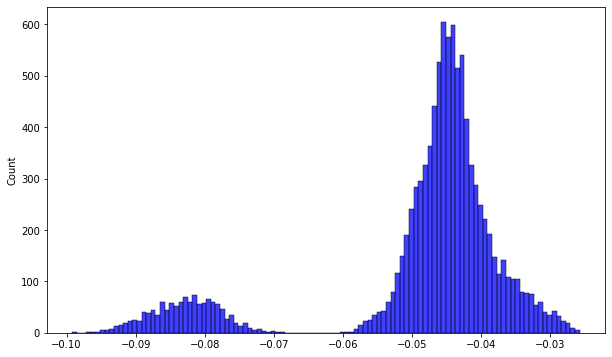

In [13]:
fig, ax = plt.subplots(1,1, figsize=(10, 6))

sns.histplot(x=cates[cates<0].reshape(-1), ax=ax, color='blue')
sns.histplot(x=cates[cates>0].reshape(-1), ax=ax, color='red')
plt.show() 

To check whether the causal forest adequately captures heterogeneity in the data, [Athey and Wager (2019)](https://arxiv.org/abs/1902.07409) propose two diagnostic tests. The first is simple. 

1. Split the sample in groups according to the estimate CATEs (e.g. using quantiles)
2. Estimate separate linear treatment effect models (could be OLS, or DML) in each othe the subsample
3. If the causal forest model adequately captures heterogeneity, the effect estimated through these models should be consistent with the average estimated CATE in the subset, and the estimated effects should increase as the average subsample CATE increases

Let's check that by splitting the sample between observations with an estimated CATE lower or higher than than $-0.065$

In [14]:
model_t = HistGradientBoostingClassifier(max_iter=100, n_iter_no_change=10, max_depth=5, early_stopping=True, random_state=cfg.random_state)
model_y = HistGradientBoostingRegressor(max_iter=100, n_iter_no_change=10, max_depth=5, early_stopping=True, random_state=cfg.random_state)
dml = LinearDML(model_t=model_t, model_y=model_y, cv=cv_splitter, discrete_treatment=True)

In [15]:
groups = np.digitize(cates, [-0.065]).reshape(-1)
modellist = []
for group in set(groups.reshape(-1)):
    modellist.append(
        deepcopy(dml).fit(y[groups==group], T.values[groups==group], W=X[groups==group])
    )

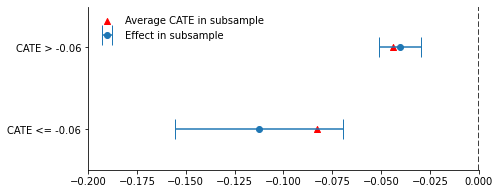

In [16]:
fig, ax = plt.subplots(1,1, figsize=(7, 3))
grps = list(set(groups))
plt.errorbar(
    [modellist[i].ate() for i in grps], grps,
    xerr=[modellist[i].ate_interval()[1] - modellist[i].ate() for i in grps],
    capsize=10, ls='none', marker='o', label='Effect in subsample'
)
plt.scatter([cates[groups==i].mean() for i in grps], grps, marker='^', color='red', label = 'Average CATE in subsample')

ax.set_ylim(min(grps)-0.5, max(grps)+0.5)
ax.set_yticks([0,1])
ax.set_yticklabels(['CATE <= -0.06', 'CATE > -0.06'])
ax.set_xlim(-0.2, 0)

ax.axvline(0, color='black', ls='--')

ax.legend(frameon=False, loc='upper left')

sns.despine()
plt.show()

Consistently with the causal forest results, effects in the two groups are very different! If anything, the CATEs estimated by the causal forest are too conservative (attenuated towards zero) for the large effect subsample.

Another test suggested by [Athey and Wager (2019)](https://arxiv.org/abs/1902.07409) is checking whether the estimated CATEs predict well (out of sample) the orthogonalized outcome, given the orthogonalized treatment. Denote 

* $\hat{\tau}^{-i}$ as the estimated CATE (the $^{-i}$ superscript means that the CATE is estimated out-of-bag, i.e. in practice using an appropriate `cv_splitter`)
* $\tilde{\tau}$ as the average estimated CATE
* $y_i - \hat{m}^{-i}(X_{i})$ the residualized outcome, where $\hat{m}^{-i}$ is the estimated first-stage (set of) model(s)
* $T_i - \hat{e}^{-i}(X_{i})$ the residualized treatment

Then we can estimate the regression 

\begin{equation}
y_i - \hat{m}^{-i}(X_{i}) = \beta_{C} \cdot \underbrace{\tilde{\tau}\left(T_i - \hat{e}^{-i}(X_{i})\right)}_{C_{i}} 
    + \beta_D \cdot \underbrace{\left(\hat{\tau}^{-i} - \tilde{\tau} \right)\left(T_i - \hat{e}^{-i}(X_{i})\right)}_{C_{i}}
\end{equation}

where the coefficient $\beta_{C}$ represents how well the CATEs capture the average treatment effect, and $\beta_{D}$ captures how well the causal forest capture heterogeneity. In a well calibrated model both coefficient should be equal to one. As Athey and Wager argue, the p-value of $\beta{D}$ can act as a test of the hypothesis that the causal forests found meaningful heterogeneity in the data.

We perform this test below.

In [17]:
import statsmodels.api as sm
residuals = DML_diagnostics(cf).first_stage_residuals(y, T, X=X)
C = cates.mean()*residuals[['T']]
D = (cates - cates.mean())*residuals[['T']]
test=pd.concat(((1-C.isna()), C, D), axis='columns')
test.columns = ['constant', 'mean_predictions', 'differential_prediction']
ols = sm.OLS(residuals[['y']], test)
res = ols.fit().get_robustcov_results(cov_type='HC3')
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.014
Model:                            OLS   Adj. R-squared:                  0.014
Method:                 Least Squares   F-statistic:                     29.97
Date:                Fri, 13 Aug 2021   Prob (F-statistic):           1.05e-13
Time:                        10:15:07   Log-Likelihood:                 2089.4
No. Observations:               10328   AIC:                            -4173.
Df Residuals:                   10325   BIC:                            -4151.
Df Model:                           2                                         
Covariance Type:                  HC3                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
constant                    0.0001      0.002      0.065      0.948      -0.004       0.004
mean_predictions            0.9460      0.129      7.310      0.000       0.692       1.200
differential_prediction     2.9540      0.656      4.503      0.000       1.668       4.240
==============================================================================
Omnibus:                     8878.062   Durbin-Watson:                   1.878
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           167481.407
Skew:                           4.344   Prob(JB):                         0.00
Kurtosis:                      20.712   Cond. No.                         196.
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC3)
"""

The `mean_predictions` coefficient ($\beta_{C}$) is close to one, suggesting that the model is well calibrated. The `differential_prediction` ($\beta_D$) coefficient however is higher than 1. This result, as we saw above, is consistent with this causal forest underestimating the effect of the treatment at the tails of the distribution.

The regularization parameters we specified when initiating the model class help with model calibration. Below is the same test, and the distribution of estimated CATEs, for a causal forest model with `econml` defaults on the same data. As you can see, not only the model is clearly not well calibrated, but the estimated distribution of CATEs is very different from that we obtain above. 

In [18]:
%%time
cfu = CausalForestDML(model_t=model_t, model_y=model_y, cv=cv_splitter, discrete_treatment=True, random_state=cfg.random_state)
cfu.fit(y, T.values, X=X)

catesu = cfu.marginal_effect(T, X=X).reshape(-1, 1)
residuals = DML_diagnostics(cfu).first_stage_residuals(y, T, X=X)
C = catesu.mean()*residuals[['T']]
D = (catesu - catesu.mean())*residuals[['T']]
test=pd.concat(((1-C.isna()), C, D), axis='columns')
test.columns = ['constant', 'mean_predictions', 'differential_prediction']
ols = sm.OLS(residuals[['y']], test)
res = ols.fit().get_robustcov_results(cov_type='HC3')
res.summary()

Wall time: 2.08 s


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.151
Model:                            OLS   Adj. R-squared:                  0.151
Method:                 Least Squares   F-statistic:                     301.1
Date:                Fri, 13 Aug 2021   Prob (F-statistic):          7.75e-128
Time:                        10:15:10   Log-Likelihood:                 2848.8
No. Observations:               10328   AIC:                            -5692.
Df Residuals:                   10325   BIC:                            -5670.
Df Model:                           2                                         
Covariance Type:                  HC3                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
constant                    0.0005      0.002      0.282      0.778      -0.003       0.004
mean_predictions            0.7089      0.113      6.289      0.000       0.488       0.930
differential_prediction     3.5240      0.144     24.449      0.000       3.241       3.807
==============================================================================
Omnibus:                     8465.400   Durbin-Watson:                   1.894
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           161293.199
Skew:                           4.021   Prob(JB):                         0.00
Kurtosis:                      20.610   Cond. No.                         62.7
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC3)
"""

Average in-sample marginal effect: -0.04366


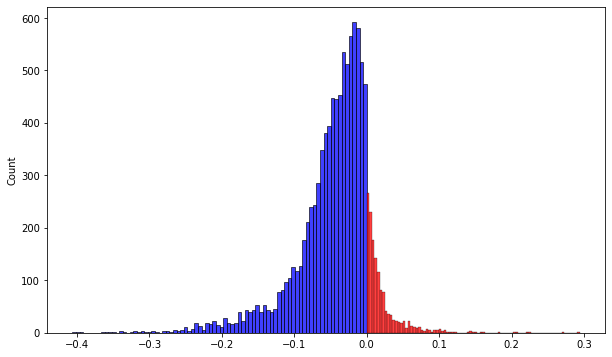

In [19]:
print(f'Average in-sample marginal effect: {catesu.mean():.5f}')
fig, ax = plt.subplots(1,1, figsize=(10, 6))

sns.histplot(x=catesu[catesu<0].reshape(-1), ax=ax, color='blue')
sns.histplot(x=catesu[catesu>0].reshape(-1), ax=ax, color='red')
plt.show() 

### Characterization of CATEs

The downside of the causal forest model is that its results tend to appear like coming from a black box. Up to now, we don't know what features driving the estimated CATEs, and what characterizes the "high-effect" subsamples from the "low-effect" one.

However, even tree-based models are not completely black-box. For example, we can extract feature importances, a measure of how much a feature has been used to split leaves in the forest. A higher feature importance value, the more often a causal forest model uses that feature to identify groups of observations characterized by different effects.

If we plot these feature importances, we see that the most important feature is whether the speed limit was less than or equal to 55 MpH. The year of the crash is also important, followed by the weight of the car, and its vintage.

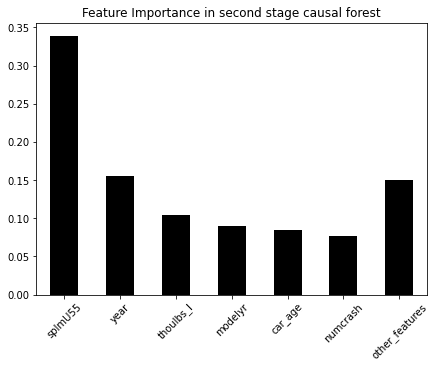

In [20]:
importances = pd.DataFrame(cf.feature_importances(), index=X.columns, columns=['importance']).sort_values('importance', ascending=False)
importances = importances[importances['importance']>0.05]
importances = pd.concat([importances, pd.DataFrame([1 - importances.sum()], index=['other_features'], columns=['importance'])])

fig, ax = plt.subplots(1,1, figsize=(7, 5))
importances.plot(kind='bar', ax=ax, legend=None, color='black')
ax.tick_params(axis='x', rotation=45)
ax.set_title('Feature Importance in second stage causal forest')
plt.show()

Armed with this knowledge, which can explore the data, and plot estimated CATEs across these variables to investigate how the effect varies as these variables change. We see that

* **Car weight** matters: Protections are more important for small cars.
* The effect seems decreasing with **time**, likely as other safety measures are implemented
* **Speed limit**, and thereby the likely speed at collision, has the largest impact. Seat protection lowers mortality twice as much where speed limits are above 55 MpH

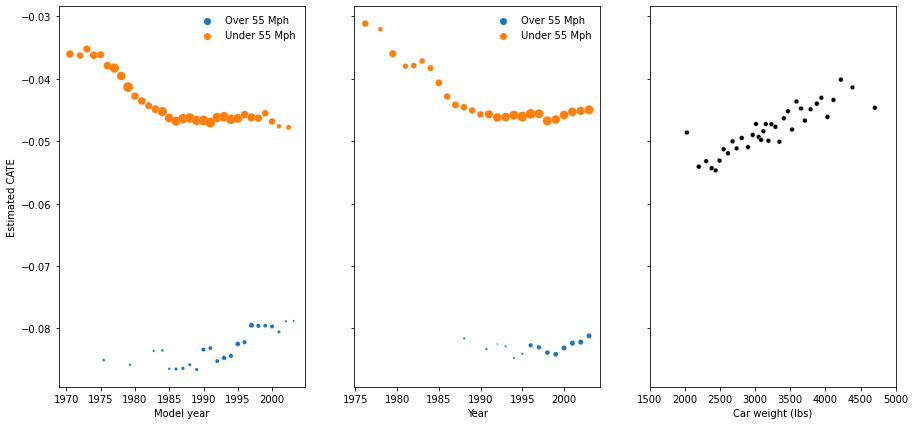

In [21]:
from src.dmlutils import binscatter
fig, ax = plt.subplots(1,3, figsize=(15, 7), sharex=False, sharey=True)

toplot = binscatter(y=pd.DataFrame(cates), x=X[['modelyr']], by=X['splmU55'], nbins=50)
sns.scatterplot(data=toplot, x='x', y='y', hue='by', s=100*toplot['count']/toplot['count'].max(), ax=ax[0])
ax[0].legend(handles= ax[0].legend_.legendHandles, labels = ['Over 55 Mph', 'Under 55 Mph'], frameon=False)
ax[0].set_ylabel('Estimated CATE')
ax[0].set_xlabel('Model year')

toplot = binscatter(y=pd.DataFrame(cates), x=X[['year']], by=X['splmU55'], nbins=50)
sns.scatterplot(data=toplot, x='x', y='y', hue='by', s=100*toplot['count']/toplot['count'].max(), ax=ax[1])
ax[1].legend(handles= ax[1].legend_.legendHandles, labels = ['Over 55 Mph', 'Under 55 Mph'], frameon=False)
ax[1].set_ylabel('Estimated CATE')
ax[1].set_xlabel('Year')

toplot = binscatter(y=pd.DataFrame(cates), x=X[['thoulbs_I']]*1000, nbins=50)
sns.scatterplot(data=toplot, x='x', y='y', s=300*toplot['count']/toplot['count'].max(), ax=ax[2], color='black')
# ax[1].set_ylabel('Estimated CATE')
ax[2].set_xlabel('Car weight (lbs)')
ax[2].set_xlim(1500,5000)

plt.show()

Indeed, if we plot the distribution of estimated CATEs sperately by speed limit, we see that the two modes in the distribution are determined by speed limit alone.

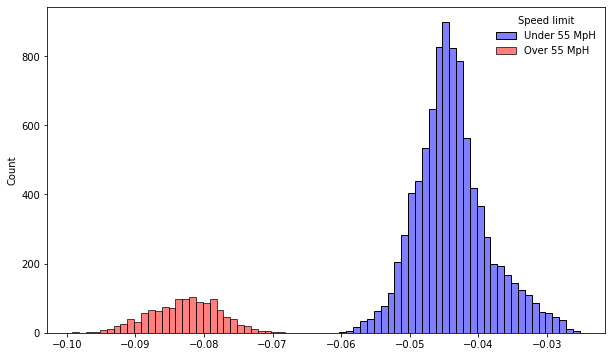

In [22]:
fig, ax = plt.subplots(1,1, figsize=(10, 6))

sns.histplot(x=cates[X['splmU55']==1].reshape(-1), ax=ax, color='blue', binwidth=0.001, alpha=0.5, label = 'Under 55 MpH')
sns.histplot(x=cates[X['splmU55']==0].reshape(-1), ax=ax, color='red', binwidth=0.001, alpha=0.5, label='Over 55 MpH')
ax.legend(frameon=False, title='Speed limit')
plt.show() 

We do not have to trust blindly the estimates of a causal forest model however. Armed with the insight gathered above, we can then test our data-driven hypotheses with a more transparent linear model. Here we are using a DML model, where the treatment coefficient is interacted with the variables highlighted above. Alternatively, we could use a standard OLS. 

Note that in the rightmost plot above I removed observations where car weight is equal to zero. These are likely missing observations. In the interactions below, we impute the average observed weight when weight is zero, and add a dummy indicating where the imputation took place.

Out test confirm some, but not all our intuitions. Speed limit is important, and so is car weight. Where the speed limit is above 55 MpH (note that the indicator in the data is equal to one when the speed limit is **under** 55Mph), seat protections are much more effective, and similarly for smaller cars. Year and model year however do not seem to matter statistically.

In [23]:
X_vars = ['splmU55', 'year', 'thoulbs_I', 'modelyr']
W = df_sel[[col for col in df_sel.columns if col not in ['lapbelt', 'lapshould', 'childseat'] + X_vars]]
W = pipe.fit_transform(W)
X = df_sel[X_vars].copy()
X.loc[:, 'missing_weight'] = X.loc[:, 'thoulbs_I']==0
X.loc[X['thoulbs_I']==0, 'thoulbs_I'] = X.loc[X['thoulbs_I']>0, 'thoulbs_I'].mean()

# Fit the model and show the coefficients
dml_interactions = LinearDML(model_t=model_t, model_y=model_y, cv=cv_splitter, discrete_treatment=True, fit_cate_intercept=True)
dml_interactions.fit(y, T.values, X=X, W=W)
dml_interactions.summary()

,point_estimate,stderr,zstat,pvalue,ci_lower,ci_upper
splmU55,0.081,0.028,2.937,0.003,0.036,0.127
year,-0.002,0.002,-0.92,0.357,-0.004,0.001
thoulbs_I,0.036,0.012,3.145,0.002,0.017,0.055
modelyr,0.0,0.001,0.141,0.888,-0.002,0.002
missing_weight,0.022,0.014,1.587,0.112,-0.001,0.045
,point_estimate,stderr,zstat,pvalue,ci_lower,ci_upper
cate_intercept,2.45,2.51,0.976,0.329,-1.678,6.579


## Policy Learning